# LeNet-5

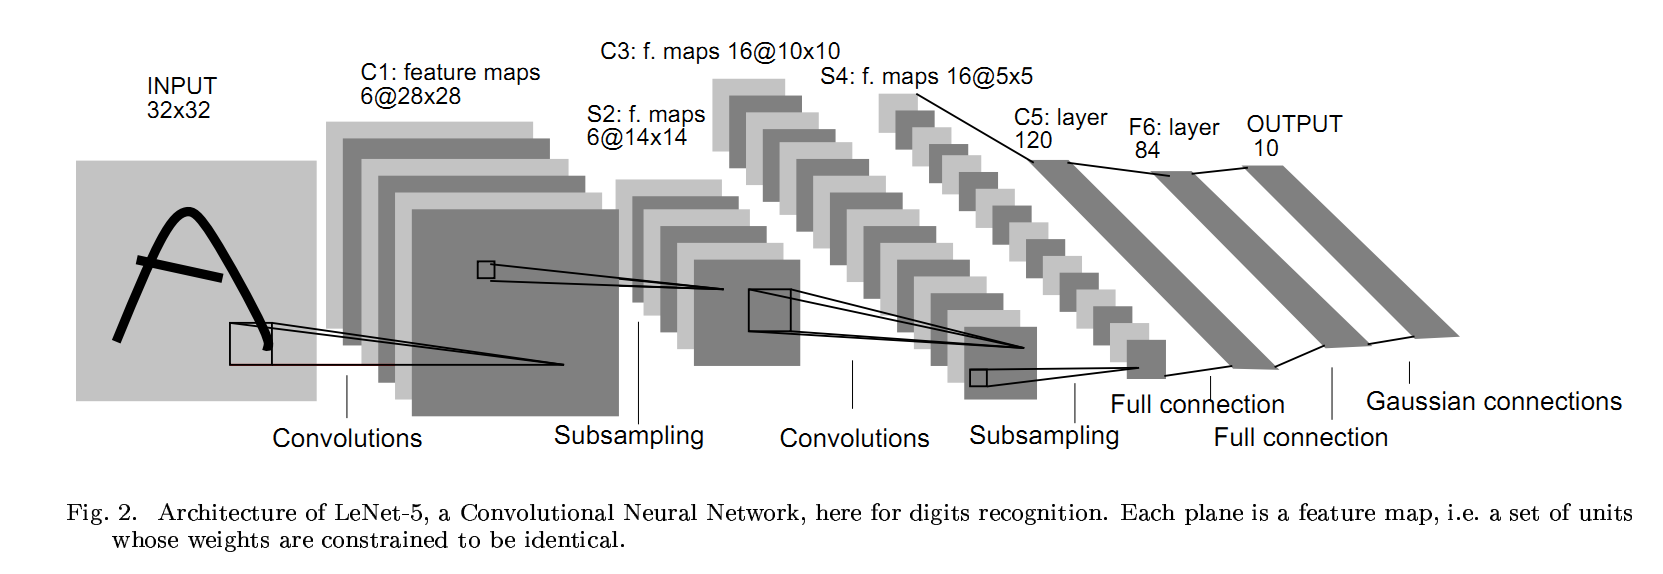

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
% matplotlib inline

## Set Hyperparameter

In [2]:
batch_size=64
learning_rate=0.002
num_epoch=10

## Data preparation

In [3]:
# Download data
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

In [4]:
train_loader=torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True, num_workers=2,drop_last=True)
test_loader=torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=2,drop_last=True)

In [5]:
class leNet_5(nn.Module):
    def __init__(self):
        super(leNet_5,self).__init__()
        
        # 흑백채널: 1 in_channel, 6 feature maps: 6 out_channels
        self.layer=nn.Sequential(
            nn.Conv2d(1,6,5,padding=1,bias=True),
            nn.Tanh(),
            nn.AvgPool2d(2,2),
            nn.Conv2d(6,16,5,padding=1,bias=True),
            nn.Tanh(),
            nn.AvgPool2d(2,2),
        )
        
        self.fc_layer=nn.Sequential(
            nn.Linear(16*5*5,120),
            nn.Tanh(),
            nn.Linear(120,84),
            nn.Tanh(),
            nn.Linear(84,10)
        )
        
    def forward(self,x):
        out=self.layer(x)
        out=out.view(batch_size,-1)
        out=self.fc_layer(out)
        
        return out

In [6]:
model=leNet_5()

# check wether GPU is available
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()
    print ('Use GPU')
else:
    print ('Use CPU')

Use CPU


## Loss function & Optimizer

In [30]:
loss_func=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=learning_rate)

In [8]:
writer = SummaryWriter(comment='test')

## Training

In [9]:
try:
    model = torch.load('./model/lenet5.pkl')
    print("\n================== Model Restored ==================\n")
except:
    print("\n============== No Model to be Restored ==============\n")
    pass


for i in range(num_epoch):
    for batch_idx,[image, label] in enumerate(train_loader):
        n_iter = (i*len(train_loader))+batch_idx
        x=Variable(image)
        y_=Variable(label)
        
        optimizer.zero_grad()
        
        output=model(x)
        
        loss=loss_func(output,y_)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx%1000==0:
            print('Training Epoch: {} \tn_iter: {} \tLoss: {:.6f}'.format(
                i+1, n_iter, loss.data[0]))
            torch.save(model,'./model/lenet5.pkl')
        
        writer.add_scalar('loss',loss.data[0] / len(x),n_iter)
        

Training Epoch: 1 	n_iter: 0 	Loss: 2.317454
Training Epoch: 2 	n_iter: 937 	Loss: 2.290159
Training Epoch: 3 	n_iter: 1874 	Loss: 2.215297
Training Epoch: 4 	n_iter: 2811 	Loss: 1.962980
Training Epoch: 5 	n_iter: 3748 	Loss: 1.471402
Training Epoch: 6 	n_iter: 4685 	Loss: 1.071297
Training Epoch: 7 	n_iter: 5622 	Loss: 0.661439
Training Epoch: 8 	n_iter: 6559 	Loss: 0.819804
Training Epoch: 9 	n_iter: 7496 	Loss: 0.615075
Training Epoch: 10 	n_iter: 8433 	Loss: 0.613519


# Test

In [10]:
import pickle
from tqdm import *

In [11]:
with open("bulk_mnist_fgsd.pkl", "rb") as f: 
    adv_data_dict = pickle.load(f) 

images = adv_data_dict["xs"]
noises  = adv_data_dict["noises"]
true_labels = adv_data_dict["y_trues"]

## Test with normal test set

In [14]:
i=0
clean_images=[]
clean_labels=[]
my_batches=[]
for image, noise ,label in tqdm(zip(images, noises,true_labels)):
    
    
    image=torch.from_numpy(image.reshape(28,28))
    image=image.unsqueeze(0)
    image=image.unsqueeze(0)
    
    clean_images.append(image)
    clean_labels.append(label[0])
    
    i+=1
    
    if i%batch_size==0:
        my_batches.append((torch.cat(clean_images,0),np.array(clean_labels)))
        clean_images=[]
        clean_labels=[]

4817it [00:00, 101626.52it/s]


In [15]:
correct = 0
total = 0

for image, label in tqdm(my_batches):
    
    x = Variable(image,volatile=True)
    y_= Variable(torch.from_numpy(np.array(label)))
    
    output = model.forward(x)
    _,output_index = torch.max(output,1)
    
    total += y_.size(0)
    correct += (output_index == y_).sum().float()
    
print("Accuracy for Clean Data: {}".format(100*correct/total))

100%|██████████| 75/75 [00:00<00:00, 104.46it/s]


Accuracy for Clean Data: Variable containing:
 90.6667
[torch.FloatTensor of size 1]



## Test with Adversarial attack set

In [16]:
i=0
noise_images=[]
clean_labels=[]
my_batches=[]
for image, noise ,label in tqdm(zip(images, noises,true_labels)):
    
    
    image=torch.from_numpy(image.reshape(28,28))
    image=image.unsqueeze(0)
    image=image.unsqueeze(0)
    
    noise=torch.from_numpy(noise.reshape(28,28))
    noise=noise.unsqueeze(0)
    noise=noise.unsqueeze(0)
    
    noise_added=image+noise
    
    noise_images.append(noise_added)
    clean_labels.append(label[0])
    
    i+=1
    
    if i%batch_size==0:
        my_batches.append((torch.cat(noise_images,0),np.array(clean_labels)))
        noise_images=[]
        clean_labels=[]

4817it [00:00, 40603.88it/s]


In [17]:
correct = 0
total = 0

for image, label in tqdm(my_batches):
    
    x = Variable(image,volatile=True)
    y_= Variable(torch.from_numpy(np.array(label)))
    
    output = model.forward(x)
    _,output_index = torch.max(output,1)
    
    total += y_.size(0)
    correct += (output_index == y_).sum().float()
    
print("Accuracy for Adversarial Attack Data: {}".format(100*correct/total))

100%|██████████| 75/75 [00:00<00:00, 103.17it/s]

Accuracy for Adversarial Attack Data: Variable containing:
 65.4792
[torch.FloatTensor of size 1]



# Defense model: convVAE

In [28]:
d_learning_rate=0.003
d_num_epoch=2
leak=0.05
drop_rate=0.02
z_dim=20

### Encoder
* Two outputs
    * z_mu
    * z_logvar

In [18]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        
        # output size = (image_width - kernel_width)/stride +1
        
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size,
        #                 stride=1, padding=0, dilation=1,
        #                 groups=1, bias=True)

        
        self.conv_layer = nn.Sequential(
                        nn.Conv2d(1,10,3,padding=1),  # ((28+1*2) - 3)/1 +1 = 28
                        nn.ReLU(),
                        nn.BatchNorm2d(10),
                        nn.Dropout(p=drop_rate,inplace=True),
                        # batch_size*  28*28  *10 featuremaps
            
                        nn.Conv2d(10,16,3,padding=1), # ((28+1*2) - 3)/1 +1 = 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Dropout(p=drop_rate,inplace=True),
                        nn.MaxPool2d(2,2),
                        # batch_size*  14*14  *16 featuremaps
                
                        nn.Conv2d(16,28,3, padding=1),  # ((28+1*2) - 3)/1 +1 = 28
                        nn.ReLU(),
                        nn.BatchNorm2d(28),
                        nn.MaxPool2d(2,2),
                        # batch_size*  7*7  *28 featuremaps
            
        )
        
        self.fc_layer = nn.Sequential(
                        nn.Linear(7*7*28,512),
                        nn.LeakyReLU(leak),
                        nn.Linear(512,128),
                        nn.LeakyReLU(leak)
        )
   
        # ===== Two output vectors generated by the Encoder =====
        
        # One for z_mu
        self.z_mu=nn.Sequential(
            nn.Linear(128,z_dim),
            nn.LeakyReLU(leak)
        )
        
        # Another for z_logvar
        self.z_logvar=nn.Sequential(
            nn.Linear(128,z_dim),
            nn.LeakyReLU(leak)
        )
        
        
    def forward(self,x):
        out=self.conv_layer(x)
        out=out.view(batch_size,-1)
        
        out=self.fc_layer(out)

        z_mu=self.z_mu(out)
        z_logvar=self.z_logvar(out)
        
        return z_mu,z_logvar

### Decoder
* input: sampled_z
* output: reconstructed image

In [19]:
# torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
#   output_padding=0, groups=1, bias=True, dilation=1)

# H_out=(H_in−1)∗stride(4th) + kernel_size(3rd) − 2∗padding(5th) + output_padding

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        self.fc_layer=nn.Sequential(
            nn.Linear(z_dim,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(leak),
            nn.Dropout(p=drop_rate,inplace=True),
            
            nn.Linear(128,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(leak),
            nn.Dropout(p=drop_rate,inplace=True),
            
            nn.Linear(256,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(leak),
            nn.Dropout(p=drop_rate,inplace=True),
            
            nn.Linear(512,784),
            nn.BatchNorm1d(784),
            nn.LeakyReLU(leak)
        )
        
        self.transConv_layer=nn.Sequential(
            nn.ConvTranspose2d(16,10,3,2,1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.ConvTranspose2d(10,6,3,2,1,1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.ConvTranspose2d(6,1,3,1),
            nn.Sigmoid()
        )
    
    # decode the sampled_z
    def forward(self,sampled_z):

        out=self.fc_layer(sampled_z)
        out=out.view(batch_size,-1,7,7)
        out=self.transConv_layer(out)

        return out

### the Model as a whole
* encoder & decoder
* sample z

In [20]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE,self).__init__()
        
        self.encoder=encoder
        self.decoder=decoder
    
    def sample_z(self, z_mu,z_logvar):
        
        # sample epsilon ~ N(0, 1)
        epsilon=Variable(torch.randn(batch_size,z_dim),requires_grad=False)
        
        # reparameterization trick
        sampled_z=z_mu+torch.mul(torch.exp(z_logvar),epsilon)
       
        return sampled_z
        
            
    def forward(self,x):
        # encode the latent variable from the image
        # sample z from the encoded result
        # decode the sampled z
        
        z_mu,z_logvar=self.encoder(x)
        
        self.z_mu=z_mu
        self.z_logvar=z_logvar

        sampled_z=self.sample_z(z_mu,z_logvar)

        result=self.decoder(sampled_z)
        
        return result

In [23]:
defense_model=VAE(Encoder(),Decoder())

In [31]:
def defense_loss_func(generated_image,x,z_mu,z_logvar):
    
    recon=nn.BCELoss(size_average=False)
    reconstruction_loss=recon(generated_image,x)
    
    # alias the KL-divergence term
    latent_loss=-0.5*torch.sum(1+z_logvar-z_mu**2-z_logvar.exp())
    
    return reconstruction_loss+latent_loss

In [29]:
defense_optimizer=optim.Adam(defense_model.parameters(),lr=d_learning_rate)


============== No Model to be Restored ==============

Training Epoch: 0 	n_iter: 0 	Loss: 32428.873047


/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Training Epoch: 0 	n_iter: 50 	Loss: 14642.424805
Training Epoch: 0 	n_iter: 100 	Loss: 12447.686523
Training Epoch: 0 	n_iter: 150 	Loss: 11530.822266
Training Epoch: 0 	n_iter: 200 	Loss: 10908.888672
Training Epoch: 0 	n_iter: 250 	Loss: 11244.662109
Training Epoch: 0 	n_iter: 300 	Loss: 10565.905273
Training Epoch: 0 	n_iter: 350 	Loss: 10236.540039
Training Epoch: 0 	n_iter: 400 	Loss: 10245.484375
Training Epoch: 0 	n_iter: 450 	Loss: 9736.802734
Training Epoch: 0 	n_iter: 500 	Loss: 10357.927734
Training Epoch: 0 	n_iter: 550 	Loss: 10349.483398
Training Epoch: 0 	n_iter: 600 	Loss: 9183.482422
Training Epoch: 0 	n_iter: 650 	Loss: 9309.847656
Training Epoch: 0 	n_iter: 700 	Loss: 9794.042969
Training Epoch: 0 	n_iter: 750 	Loss: 9537.787109
Training Epoch: 0 	n_iter: 800 	Loss: 9549.263672
Training Epoch: 0 	n_iter: 850 	Loss: 9931.972656
Training Epoch: 0 	n_iter: 900 	Loss: 9672.404297
Training Epoch: 1 	n_iter: 937 	Loss: 9459.024414
Training Epoch: 1 	n_iter: 987 	Loss: 859

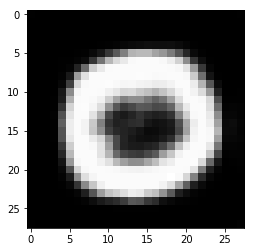

In [33]:
try:
    defense_model = torch.load('./model/conv_VAE.pkl')
    print("\n================== Model Restored ==================\n")
except:
    print("\n============== No Model to be Restored ==============\n")
    pass

for i in range(d_num_epoch):
    for batch_idx,[image,_] in enumerate(train_loader):
        n_iter = (i*len(train_loader))+batch_idx
        
        x=Variable(image)
        # x: batchsize x 1 x 28 x 28
        
        defense_optimizer.zero_grad()
        
        reconstructed_image=defense_model(x)
        
        loss=defense_loss_func(reconstructed_image,x,defense_model.z_mu,defense_model.z_logvar)
        loss.backward()
        
        defense_optimizer.step()
        
        if batch_idx%50==0:
            print('Training Epoch: {} \tn_iter: {} \tLoss: {:.6f}'.format(
                i, n_iter, loss.data[0]))
            
        if batch_idx%200==0:
            torch.save(defense_model,'./model/conv_VAE_'+str(batch_idx)+'.pkl')
            torch.save(defense_model,'./model/conv_VAE.pkl')
        
        
plt.imshow(defense_model(x).data[0].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

In [ ]:
for image, label in tqdm(my_batches):